<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/simpleNN_dropouts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# LAst amended: 2nd June, 2023
# Ref: https://www.kaggle.com/code/harnalashok/exercise-dropout-and-batch-normalization/edit
# Data Source: https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-01-21
# Spotify dataset

# About dropouts
overfitting is caused by the network learning spurious patterns in the training data. To recognize these spurious patterns a network will often rely on very a specific combinations of weight, a kind of "conspiracy" of weights. Being so specific, they tend to be fragile: remove one and the conspiracy falls apart.

This is the idea behind dropout. To break up these conspiracies, we randomly drop out some fraction of a layer's input units every step of training, making it much harder for the network to learn those spurious patterns in the training data. Instead, it has to search for broad, general patterns, whose weight patterns tend to be more robust.

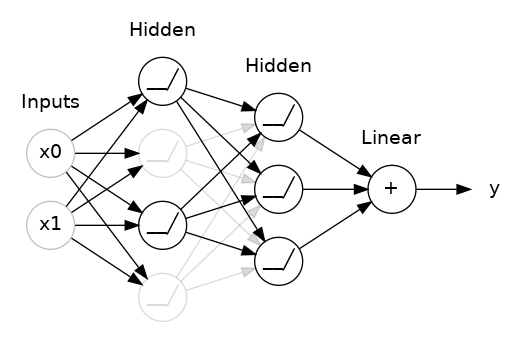

## Process data

In [1]:
# 1.0
import pandas as pd
from pathlib import Path

# 1.0.1
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

# 1.0.2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [2]:
# 1.1 Display multiple commands output from a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# 1.2
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
# 1.2.1
pathToFolder = "/gdrive/MyDrive/Colab_data_files/deeplearning"

In [5]:
# 1.2.2
path = Path(pathToFolder) / "spotify.csv.zip"

In [6]:
# 2.0 Read data:

spotify = pd.read_csv(path)

In [8]:
# 2.1
spotify.shape  # (32833, 23)
spotify.head()

(32833, 23)

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [11]:
# 2.2 
X = spotify.copy().dropna()
y = X.pop('track_popularity')

In [12]:
# 3.0 
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']

features_cat = ['playlist_genre']

In [13]:
# 3.1 Set process pipeline:

preprocessor = make_column_transformer(
                                        (StandardScaler(), features_num),
                                        (OneHotEncoder(), features_cat),
                                        )

What is GroupShuffleSplit()?<br>
See StackOverflow [here](https://stackoverflow.com/a/68983770) and [this page](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py) on different kinds of splits.

In [14]:
# 4.0 Define function to split data 
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

In [15]:
# 4.1 Split data:
X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

In [ ]:
# 4.2
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100


Input shape: [18]


In [ ]:
# 4.3

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

## Model without dropouts:

In [ ]:
# 5.0 Our 1st model:

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])


<Axes: >

Minimum Validation Loss: 0.1992


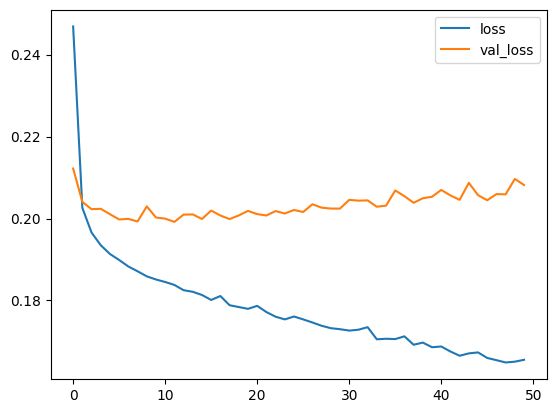

In [ ]:
# 5.1 Compile the model

model.compile(
    optimizer='adam',
    loss='mae',
)



In [ ]:
# 5.2 Fit the model:

history = model.fit(
                     X_train, y_train,
                     validation_data=(X_valid, y_valid),
                     batch_size=64,
                     epochs=50,
                     verbose=0,
                   )

In [ ]:
# 5.3 Examine results:

history_df = pd.DataFrame(history.history)


In [ ]:
# 5.4 Results:

history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

## Model with dropouts

In [ ]:
# 6.0 The model with Dropouts:

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])


<Axes: >

Minimum Validation Loss: 0.1947


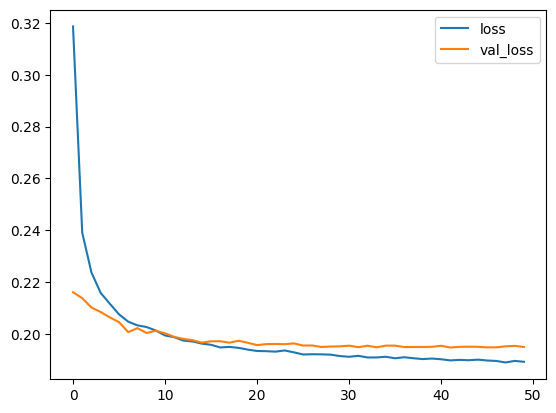

In [ ]:
# 6.1 Compile the model:

model.compile(
    optimizer='adam',
    loss='mae',
)


In [ ]:
# 6.2 Fit and plot results:

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)


In [ ]:
# 6.2.1
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [ ]:
####### Done -------------------